In [ ]:
import torch
import numpy as np
from tqdm import tqdm

#from envs.SimpleBertrandInflation import BertrandEnv
from envs.SimpleBertrandInflation_final import BertrandEnv
#from envs.BertrandInflation import BertrandEnv
from replay_buffer import ReplayBuffer
from agents.sac import SACAgent
from agents.dqn_linear import DQNAgent

N = 2
total_timesteps = 2000
rho = 1e-4
expected_shocks = int(total_timesteps * rho)

env = BertrandEnv(N = N, k = 2, rho = rho, A = 3, c = 1)
#env = BertrandEnv(N = N, k = 2, rho = rho, c = 1)

ob_t = env.reset()
dim_states = env.k * env.N + env.k + 1
dim_actions = 15

action_low = env.price_low
action_high = env.price_high * (1.05 ** expected_shocks)

#agents = [SACAgent(dim_states, dim_actions, action_low, action_high) for _ in range(N)]
agents = [DQNAgent(dim_states, dim_actions, action_low, action_high, epsilon=1e-3) for _ in range(N)]
buffer = ReplayBuffer(N, buffer_size = 1000000, sample_size = 64)

trigger_deviation = True

for timestep in tqdm(range(total_timesteps)):
    
    actions = [agent.select_action(ob_t) for agent in agents]   
    
    if (timestep > 1000) & (trigger_deviation):
        actions[0] = env.pN
     
    ob_t1, rewards, done, info = env.step(actions)
    
    # update scale
    if ob_t1[0].item() > 0:
        [agent.update_scale(env.price_low, env.price_high) for agent in agents]
    
    experience = (ob_t, actions, rewards, ob_t1, done)
    
    buffer.store_transition(*experience)
    
    if timestep > buffer.sample_size:
        for agent_idx in range(N):
            agent = agents[agent_idx]
            sample = buffer.sample(agent_idx)
            agent.update(*sample)
            
    ob_t = ob_t1

In [ ]:
a = torch.tensor(0.54)

a.long().dtype

In [ ]:
import matplotlib.pyplot as plt
from utils.plot_metrics import plot_metrics

plot_dim = (1, 3)
fig, axes = plt.subplots(*plot_dim, figsize = (16, 4))
axes = np.array(axes, ndmin = 2)

plot_args = (fig, axes, env.prices_history, env.monopoly_history, env.nash_history, env.rewards_history, env.metric_history, 1000)
plot_metrics(*plot_args)     

In [ ]:
total_timesteps = 100_000
rho = 1e-6

expected_shocks = int(total_timesteps * rho)

action_low = env.price_low # ver como se calcula el action_low desde env
action_high = env.price_high * (1.1 ** expected_shocks)

action_high

1. Cambiar precios a logaritmo natural para evitar explosiones en grafico

2. Limite muy amplio de acciones hace que agente converja de forma mal, repasar forma usando promedio móvil
    --> convertir acciones a diferencial (repasar mensaje de Francisco)

3. Añadir `wandb`?

4. Cambiar recompensas a recompensas sobre costos?

5. Recompensas en ambiente Bertrand se reducen al aumentar los precios
    --> delta precio < delta cantidad
    --> buscar manera para que las cantidades se mantengan constantes ante un cambio positivo en el precio

6. agregar nivel de precios **P** como observacion y deflactor a la demanda?

7. cambiar ambiente para que price_low y price_high se determinen antes de reset

In [6]:
import pandas as pd
import numpy as np
from ast import literal_eval
import matplotlib.pyplot as plt
from utils.plot_metrics import get_rolling

df = pd.read_csv('metrics/bertrand.csv', sep = '\t', index_col = 0)

df['prices_history'] = df['prices_history'].apply(literal_eval).apply(lambda x: x[0])
df['quantities_history'] = df['quantities_history'].apply(literal_eval).apply(lambda x: x[0])
df['rewards_history'] = df['rewards_history'].apply(literal_eval).apply(lambda x: x[0])

df['ingresos'] = df['prices_history'] * df['quantities_history']
df['costos'] = df['costs_history'] * df['quantities_history']

df

,prices_history,quantities_history,rewards_history,costs_history,monopoly_history,nash_history,metric_history,ingresos,costos
0,1.929267,0.419217,0.389565,1,1.924981,1.472927,0.961265,0.808782,0.419217
1,1.668778,0.736646,0.492653,1,1.924981,1.472927,0.577419,1.229299,0.736646
2,2.225105,0.023345,0.028600,1,1.924981,1.472927,-0.590148,0.051945,0.023345
3,1.427685,0.673598,0.288088,1,1.924981,1.472927,0.063434,0.961685,0.673598
4,1.832291,0.574272,0.477962,1,1.924981,1.472927,0.831843,1.052234,0.574272
...,...,...,...,...,...,...,...,...,...
19995,2.240335,0.214228,0.265714,1,1.924981,1.472927,0.421984,0.479942,0.214228
19996,1.629493,0.607728,0.382561,1,1.924981,1.472927,0.663914,0.990289,0.607728
19997,2.227370,0.186874,0.229364,1,1.924981,1.472927,0.687191,0.416238,0.186874
19998,1.546594,0.498352,0.272396,1,1.924981,1.472927,0.323853,0.770748,0.498352


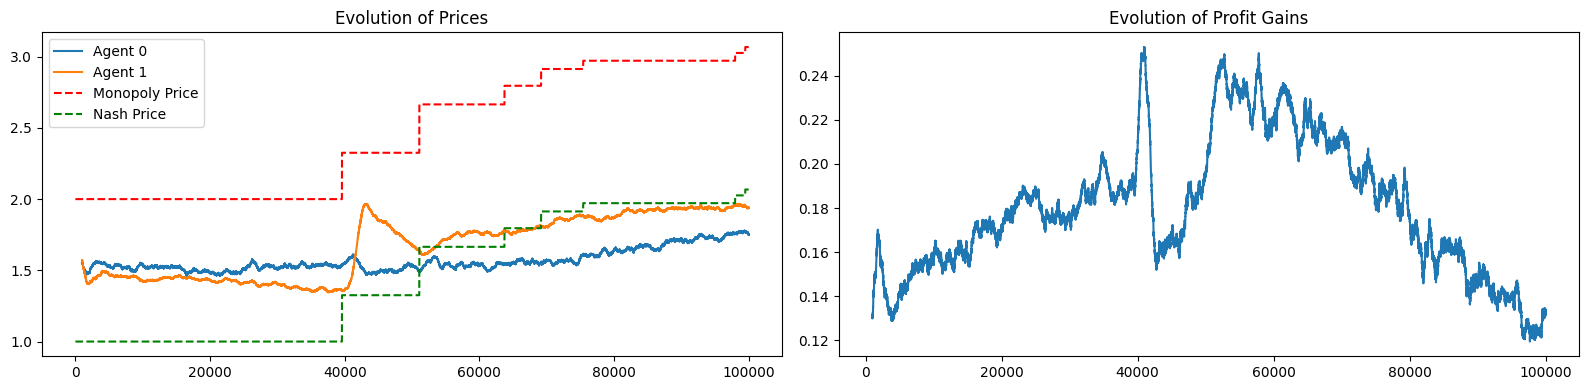

In [7]:
from ast import literal_eval
import matplotlib.pyplot as plt
from utils.plot_metrics import get_rolling

df = pd.read_csv('metrics/sac_gamma_1_1.csv', sep = '\t', index_col = 0)
df['prices_history'] = df['prices_history'].apply(literal_eval)

fig, axes = plt.subplots(1, 2, figsize = (16, 4))

for agent in range(2):
    series = get_rolling(np.log(df['prices_history'].apply(lambda x: x[agent])), 1000)
    axes[0].plot(series, label = f'Agent {agent}')
axes[0].plot(df['monopoly_history'], label = 'Monopoly Price', color = 'red', linestyle = '--')
axes[0].plot(df['nash_history'], label = 'Nash Price', color = 'green', linestyle = '--')
axes[0].set_title('Evolution of Prices')
axes[0].legend()

series = get_rolling(df['metric_history'], 1000)
axes[1].plot(series)
axes[1].set_title('Evolution of Profit Gains')

plt.tight_layout()
plt.savefig('figures/agg_experiments/sample_experiment.pdf')

In [10]:
import pandas as pd
from ast import literal_eval
import matplotlib.pyplot as plt
import numpy as np
from utils.plot_metrics import get_rolling

experiments = ['sac_lr', 'sac_N', 'sac_gamma', 'sac_rho', 'sac_k']

#for experiment in experiments:
    
#    df = pd.read_csv(f'metrics/{experiment}_1_1.csv', sep = '\t', index_col = 0)
#    df['prices_history'] = df['prices_history'].apply(literal_eval)
#    df['quantities_history'] = df['quantities_history'].apply(literal_eval)
#    df['rewards_history'] = df['rewards_history'].apply(literal_eval)
    
#    plt.figure(figsize = (12, 4))
#    agents = len(df['prices_history'].iloc[0])
#    for agent in range(agents):
#        series = get_rolling(np.log(df['prices_history'].apply(lambda x: x[agent])), 1000)
#        plt.plot(series, label = f'Agent {agent}')
#    plt.plot(df['monopoly_history'], label = 'Monopoly Price', color = 'red')
#    plt.plot(df['nash_history'], label = 'Nash Price', color = 'green')
#    plt.title(f"Sample experiment")
#    plt.xlabel('Timestep')
#    plt.ylabel('Price')
#    plt.legend()
#    plt.show()

In [44]:
models = set([config.split('_')[0] for config in os.listdir('configs')])
params = set([config.split('_')[1] for config in os.listdir('configs') if 'base' not in config])

params

{'N', 'gamma', 'k', 'lr', 'rho'}

['sac_base', 'sac_gamma_1', 'sac_gamma_2']
['sac_base', 'sac_rho_1', 'sac_rho_2']
['sac_base', 'sac_lr_1', 'sac_lr_2']
['sac_base', 'sac_N_1', 'sac_N_2']
['sac_base', 'sac_k_1', 'sac_k_2']


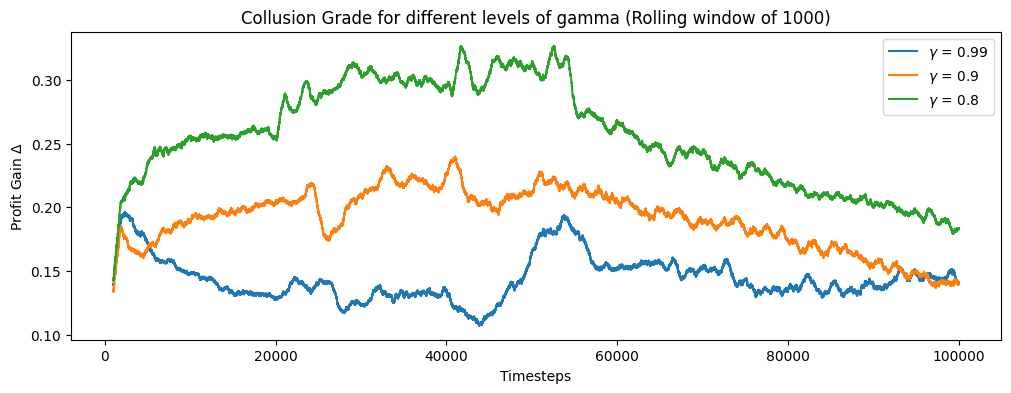

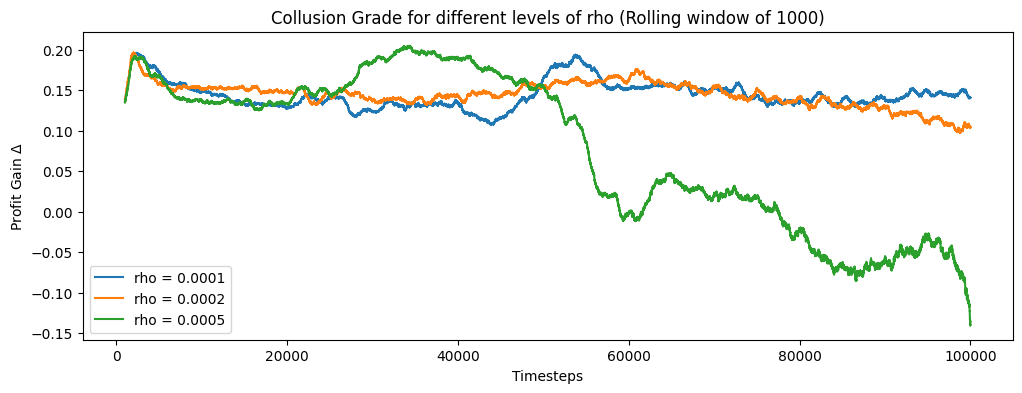

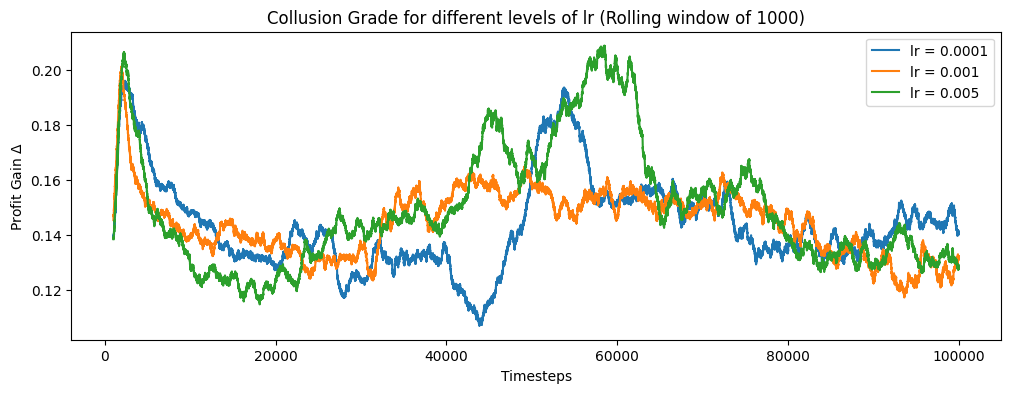

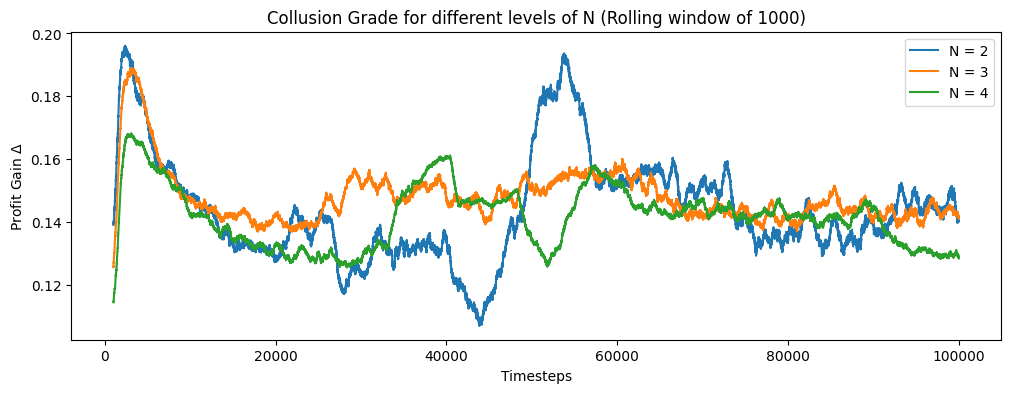

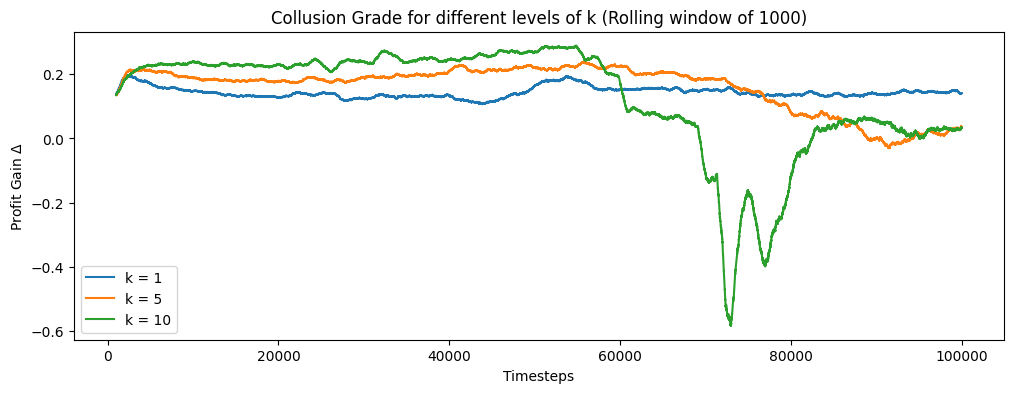

In [50]:
import pandas as pd
import os 
import matplotlib.pyplot as plt
from utils.plot_metrics import get_rolling

dict_labels = {
    'sac_lr': {
        'sac_base': 'lr = 0.0001',
        'sac_lr_1': 'lr = 0.001',
        'sac_lr_2': 'lr = 0.005'
        },
    'sac_N': {
        'sac_base': 'N = 2',
        'sac_N_1': 'N = 3',
        'sac_N_2': 'N = 4'  
    },
    'sac_gamma': {
        'sac_base': '$\gamma$ = 0.99',
        'sac_gamma_1': '$\gamma$ = 0.9',
        'sac_gamma_2': '$\gamma$ = 0.8'
    },
    'sac_rho': {
        'sac_base': 'rho = 0.0001',
        'sac_rho_1': 'rho = 0.0002',
        'sac_rho_2': 'rho = 0.0005'
        },
    'sac_k': {
        'sac_base': 'k = 1',
        'sac_k_1': 'k = 5',
        'sac_k_2': 'k = 10'
    },
} 

dict_labels = {
    'lr': {
        'base': 'lr = 0.0001',
        'lr_1': 'lr = 0.001',
        'lr_2': 'lr = 0.005'
        },
    'N': {
        'base': 'N = 2',
        'N_1': 'N = 3',
        'N_2': 'N = 4'  
    },
    'gamma': {
        'base': '$\gamma$ = 0.99',
        'gamma_1': '$\gamma$ = 0.9',
        'gamma_2': '$\gamma$ = 0.8'
    },
    'rho': {
        'base': 'rho = 0.0001',
        'rho_1': 'rho = 0.0002',
        'rho_2': 'rho = 0.0005'
        },
    'k': {
        'base': 'k = 1',
        'k_1': 'k = 5',
        'k_2': 'k = 10'
    },
}

def get_avg(config, n_experiments = 3):
    
    '''
    Returns the average metric per step between all experiments
    '''
    
    files = [config + f'_{idx}' for idx in range(1, n_experiments + 1)]

    dataframe = pd.DataFrame()
    for file in files:
        df_tmp = pd.read_csv(f'metrics/{file}.csv', sep = '\t')
        dataframe[f'metric_{file}'] = df_tmp['metric_history']

    return dataframe.mean(axis = 1)

def plot_delta(model, param, trigger = False):
    exp_name = f'{model}_{param}'
    configs = sorted([config.replace('.yaml', '') for config in os.listdir('configs') if (exp_name in config) & ('trigger' not in config)])
    configs = [f'{model}_base'] + configs

    print(configs)

    plt.figure(figsize = (12, 4))

    for config in configs:
        config_series = get_rolling(get_avg(config), 1000)
        plt.plot(config_series, 
                 #label = config
                 #label = dict_labels[exp_name][config]
                 label = dict_labels[param][config.replace(f'{model}_', '')]
                 ) # cambiar label a diccionario
        
    variable = exp_name.split('_')[1]

    plt.title(f'Collusion Grade for different levels of {variable} (Rolling window of 1000)')
    plt.xlabel('Timesteps')
    plt.ylabel('Profit Gain $\Delta$')
    plt.legend()
    plt.savefig(f'figures/agg_experiments/{exp_name}_metric.pdf')
 
models = set([config.split('_')[0] for config in os.listdir('configs')])
params = set([config.split('_')[1] for config in os.listdir('configs') if 'base' not in config])
    
for model in models:
    for param in params:
        plot_delta(model, param)

In [35]:
#['sac_lr_1', 'sac_lr_2']

[config for config in os.listdir('configs') if ('sac_lr' in config) & ('trigger' not in config)]

['sac_lr_2.yaml', 'sac_lr_1.yaml']

In [30]:
models = set([cfg.split('_')[0] for cfg in os.listdir('configs')])

for model in models:
    configs = [config.replace('.yaml', '') for config in os.listdir('configs') if ('trigger' not in config) & (model in config)]
    print(configs)
    for config in configs:
        files = [config + f'_{idx}' for idx in range(1, n_experiments + 1)]
        averages = []
        for file in files:
            df_tmp = pd.read_csv(f'metrics/{file}.csv', sep = '\t')
            metric_array = df_tmp['metric_history']#[-20000:]
            avg_metric = np.mean(metric_array)
            
            averages += [avg_metric]
            
        avg_dict[config] = np.mean(averages)

results = pd.DataFrame(avg_dict, index = ['metric']).T
results['base_diff'] = results['metric'] - avg_dict['sac_base']
results.sort_values(by = 'base_diff', ascending = False)

['sac_rho_2', 'sac_lr_2', 'sac_gamma_1', 'sac_k_1', 'sac_N_2', 'sac_gamma_2', 'sac_k_2', 'sac_N_1', 'sac_lr_1', 'sac_rho_1', 'sac_base']


,metric,base_diff
sac_gamma_2,0.254722,0.110869
sac_gamma_1,0.190388,0.046534
sac_k_1,0.159612,0.015758
sac_lr_2,0.149646,0.005792
sac_N_1,0.147745,0.003891
sac_lr_1,0.144655,0.000801
sac_rho_1,0.144458,0.000604
sac_base,0.143854,0.000000
sac_N_2,0.141486,-0.002368
sac_k_2,0.126441,-0.017413


In [12]:
configs = ['sac_base', 'sac_lr_1', 'sac_lr_2', 'sac_gamma_1', 'sac_gamma_2', 'sac_k_1', 
           'sac_k_2', 'sac_N_1', 'sac_N_2', 'sac_rho_1', 'sac_rho_2']

n_experiments = 3

avg_dict = {}
for config in configs:
    files = [config + f'_{idx}' for idx in range(1, n_experiments + 1)]
    averages = []
    for file in files:
        df_tmp = pd.read_csv(f'metrics/{file}.csv', sep = '\t')
        metric_array = df_tmp['metric_history']#[-20000:]
        avg_metric = np.mean(metric_array)
        
        averages += [avg_metric]
        
    avg_dict[config] = np.mean(averages)
        
results = pd.DataFrame(avg_dict, index = ['metric']).T
results['base_diff'] = results['metric'] - avg_dict['sac_base']
results.sort_values(by = 'base_diff', ascending = False)

,metric,base_diff
sac_gamma_2,0.254722,0.110869
sac_gamma_1,0.190388,0.046534
sac_k_1,0.159612,0.015758
sac_lr_2,0.149646,0.005792
sac_N_1,0.147745,0.003891
sac_lr_1,0.144655,0.000801
sac_rho_1,0.144458,0.000604
sac_base,0.143854,0.000000
sac_N_2,0.141486,-0.002368
sac_k_2,0.126441,-0.017413
